In [1]:
from lusidtools.jupyter_tools import toggle_code

"""Private Markets and Real Estate

Attributes
----------
private markets
real estate
cash flows
quotes
transactions
excel
pdf
lookthrough
"""

toggle_code("Toggle Docstring")

# Private Markets and Real Estate

This notebook will show the creation of a private markets and real estate environment, suitable for modelling cash flows and portfolio securitization, among other things.

The following list provides a step-by-step overview of the sections that will be covered. More detail on each section will be provided as we move through this notebook.

Load data
1. **[Setup LUSID](#1.-Setup-LUSID)**
    - Packages
2. **[Properties & Portfolios](#2.-Properties-&-Portfolios)**
3. **[Securitise Porfolios](#3.-Securitise-portfolios)**
4. **[Book in Cash](#4.-Book-in-Cash)**
    - Capital Commitments
    - Capital Calls
    - Expenses
5. **[Load Data into Portfolios](#5.-Load-Data-into-Portfolios)**
    - Private Equity Fund Instruments
    - Real Estate Fund Instruments
    - Private Debt Fund Instruments
    - Transactions
    - Quotes
    - Recipes
8. **[Excel Report Writer](#6.-Excel-ILPA-Report-Writer-(for-General-Partnership))** (for General Partnership)
    - Data Consolidation
    - Excel Output
6. **[Real Estate Cash Flows](#7.-Real-Estate-Cash-Flows)**
    - Override Cash Flows
    - Book Bond
    - Data Calculations
    - Data Visualisation
7. **[PDF Report Writer](#8.-PDF-Report-Writer-(for-Real-Estate-Fund))** (for Real Estate Fund)

In [2]:
!pip install fpdf

# 1. Setup LUSID

Import modules (both LUSID and non-LUSID) and define our API factories.

In [3]:
# Import generic non-LUSID packages
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import pytz
import time
from IPython.core.display import HTML
import openpyxl
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from dateutil.relativedelta import relativedelta
from fpdf import FPDF
from IPython.display import IFrame

# Import key modules from the LUSID package
import lusid as lu
import lusid.models as lm

# Import key functions from Lusid-Python-Tools and other packages
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame
from lusidtools.cocoon.cocoon import load_from_data_frame
from lusidtools.cocoon.cocoon_printer import (
    format_instruments_response,
    format_holdings_response,
    format_portfolios_response,
    format_transactions_response,
    format_quotes_response,)
from lusidtools.cocoon.transaction_type_upload import upsert_transaction_type_alias
from lusidtools.lpt.lpt import to_date
from lusidjam import RefreshingToken
import lusid_drive

# Set DataFrame display formats
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = "{:,.2f}".format

# Set the secrets path
secrets_path = os.getenv("FBN_SECRETS_PATH")

# For running the notebook locally
if secrets_path is None:
    secrets_path = os.path.join(os.path.dirname(os.getcwd()), "secrets.json")

# Authenticate our user and create our API client
api_factory = lu.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename=secrets_path
)

print("LUSID Environment Initialised")
print(
    "LUSID API Version :",
    api_factory.build(lu.api.ApplicationMetadataApi).get_lusid_versions().build_version,
)

LUSID Environment Initialised
LUSID API Version : 0.6.11051.0


In [4]:
# LUSID Variable Definitions
transaction_portfolios_api = api_factory.build(lu.api.TransactionPortfoliosApi)
instruments_api = api_factory.build(lu.api.InstrumentsApi)
property_definitions_api = api_factory.build(lu.api.PropertyDefinitionsApi)
configuration_recipe_api = api_factory.build(lu.api.ConfigurationRecipeApi)
structured_result_data_api = api_factory.build(lu.api.StructuredResultDataApi)
aggregation_api = api_factory.build(lu.api.AggregationApi)
transaction_config_api = api_factory.build(lu.api.TransactionConfigurationApi)

In [5]:
scope = "privateMarkets"

# 2. Properties & Portfolios

First, we need to instantiate our properties and portfolios.

The properties we create are:
1. **Investor**: Investor who is responsible for a transaction
2. **Holding Class**:  Class that the holding can be categorised into
3. **Expense Type**: Category of an expense (only for expense transactions)

We also create 4 portfolios:
1. **General Partnership**
2. **Real Estate Fund**
3. **Private Equity Fund**
4. **Private Debt Fund**

The following diagram illustrates the structure of funds that we are building out, with each box representing a portfolio.

We are able to associate the Real Estate, Private Equity and Private Debt fund portfolios with the General Partnership fund through a process called 'securitisation'. We will cover this in more detail during the next section.

![Image showing fund structure of this notebook](./data/fund_structure.png "Fund Structure")

In [6]:
try:
    resp = property_definitions_api.create_property_definition(
        create_property_definition_request=lm.CreatePropertyDefinitionRequest(
            domain="Transaction",
            scope=scope,
            code="investor",
            value_required=None,
            display_name="Investor",
            data_type_id=lm.ResourceId(scope="system", code="string"),
            life_time=None,
        )
    )
    print(f"{resp.key} property created")
    
except lu.ApiException as e:
    if json.loads(e.body)["code"] == 124: # PropertyAlreadyExists
        print(json.loads(e.body)["title"])
    else:
        raise e

Transaction/privateMarkets/investor property created


In [7]:
try:
    resp = property_definitions_api.create_property_definition(
        create_property_definition_request=lm.CreatePropertyDefinitionRequest(
            domain="Transaction",
            scope=scope,
            code="holding_class",
            value_required=None,
            display_name="Holding Class",
            data_type_id=lm.ResourceId(scope="system", code="string"),
            life_time=None,
        )
    )
    print(f"{resp.key} property created")
    
except lu.ApiException as e:
    if json.loads(e.body)["code"] == 124: # PropertyAlreadyExists
        print(json.loads(e.body)["title"])
    else:
        raise e

Transaction/privateMarkets/holding_class property created


In [8]:
try:
    resp = property_definitions_api.create_property_definition(
        create_property_definition_request=lm.CreatePropertyDefinitionRequest(
            domain="Transaction",
            scope=scope,
            code="expense_type",
            value_required=None,
            display_name="Expense Type",
            data_type_id=lm.ResourceId(scope="system", code="string"),
            life_time=None,
        )
    )
    print(f"{resp.key} property created")
    
except lu.ApiException as e:
    if json.loads(e.body)["code"] == 124: # PropertyAlreadyExists
        print(json.loads(e.body)["title"])
    else:
        raise e

Transaction/privateMarkets/expense_type property created


In [9]:
main_portfolio = "generalPartnership"

try:
        resp = transaction_portfolios_api.create_portfolio(
            scope=scope,
            create_transaction_portfolio_request=lm.CreateTransactionPortfolioRequest(
                display_name=main_portfolio,
                code=main_portfolio,
                base_currency="GBP",
                created="2021-01-01",
                sub_holding_keys=[f"Transaction/{scope}/investor", f"Transaction/{scope}/holding_class"],
            ),
        )
        print(f"{resp.display_name} portfolio created")

except lu.ApiException as e:
    if json.loads(e.body)["code"] == 112: # PortfolioWithIdAlreadyExists
        print(json.loads(e.body)["title"])
    else:
        raise e

generalPartnership portfolio created


In [10]:
real_estate = "realEstateFund"

try:
        resp = transaction_portfolios_api.create_portfolio(
            scope=scope,
            create_transaction_portfolio_request=lm.CreateTransactionPortfolioRequest(
                display_name=real_estate,
                code=real_estate,
                base_currency="GBP",
                created="2021-01-01",
                sub_holding_keys=[f"Transaction/{scope}/holding_class"],
            ),
        )
        print(f"{resp.display_name} portfolio created")

except lu.ApiException as e:
    if json.loads(e.body)["code"] == 112: # PortfolioWithIdAlreadyExists
        print(json.loads(e.body)["title"])
    else:
        raise e

realEstateFund portfolio created


In [11]:
portfolio_codes = ["privateEquityFund", "privateDebtFund"]

for portfolio_code in portfolio_codes:
    try:
        resp = transaction_portfolios_api.create_portfolio(
            scope=scope,
            create_transaction_portfolio_request=lm.CreateTransactionPortfolioRequest(
                display_name=portfolio_code,
                code=portfolio_code,
                base_currency="GBP",
                created="2021-01-01",
                sub_holding_keys=[],
            ),
        )
        print(f"{resp.display_name} portfolio created")

    except lu.ApiException as e:
        if json.loads(e.body)["code"] == 112: # PortfolioWithIdAlreadyExists
            print(json.loads(e.body)["title"])
        else:
            raise e

privateEquityFund portfolio created
privateDebtFund portfolio created


# 3. Securitise Portfolios

The portfolios we have just created will now undergo a process known as 'securitisation'. By doing this, we encapsulate a portfolio into a security which then allows us to book it into a parent portfolio in the same way we would for any traditional security. In this case, we are securitising the child funds and then booking them into our General Partnership portfolio, creating a fund-of-funds architecture. 

The diagram below shows the fund structure.

![Image showing portfolio securitisation](./data/lookthrough.png "Securites Portfolios")

In [12]:
# Add our real estate fund
portfolio_codes.append("realEstateFund")
# Creating IDs for the securitised portfolios
securitised_portfolio_ids = [portfolio_code + "Securitised" for portfolio_code in portfolio_codes]
securitised_portfolios = list(zip(portfolio_codes, securitised_portfolio_ids))
securitised_portfolios

[('privateEquityFund', 'privateEquityFundSecuritised'),
 ('privateDebtFund', 'privateDebtFundSecuritised'),
 ('realEstateFund', 'realEstateFundSecuritised')]

In [13]:
# Insert the new portfolio instruments into LUSID
for portfolio, instrument_id in securitised_portfolios:
    try:
        instr_result = instruments_api.upsert_instruments(
            request_body={
                "look_through": lm.InstrumentDefinition(
                    name=portfolio,
                    identifiers={
                        "ClientInternal": lm.InstrumentIdValue(value=instrument_id)
                    },
                    look_through_portfolio_id=lm.ResourceId(scope=scope, code=portfolio),
                )
            }
        )
        print(f"Instrument {instr_result.values['look_through'].lusid_instrument_id} created")
    except lu.ApiException as e:
        raise e


Instrument LUID_00003FJD created
Instrument LUID_00003FJF created
Instrument LUID_00003FJE created


# 4. Book in Cash

Next, let's populate our portfolios with some cash. The cash will take one of three forms:

1. **Capital Commitments**
2. **Capital Calls**
3. **Expenses**

## Capital Commitments

A capital commitment is some projected capital expendature that an entity commits to spending over a set period of time. In our example, we use GBP.

In [14]:
capital_commitments = pd.read_csv("./data/cash_commitments.csv")
capital_commitments

,investor,txn_id,type,client_id,trade_date,settlement_date,quantity,price,total_consideration,currency,portfolio,holding_class
0,Investor 1,tx001,CapitalCommitment,NaN,2022-01-01T08:00:00Z,2022-01-03T08:00:00Z,"20,000,000.00",1,"20,000,000.00",GBP,generalPartnership,Cash
1,Investor 2,tx002,CapitalCommitment,NaN,2022-01-01T08:00:00Z,2022-01-03T08:00:00Z,"5,000,000.00",1,"5,000,000.00",GBP,generalPartnership,Cash
2,Investor 3,tx003,CapitalCommitment,NaN,2022-01-01T08:00:00Z,2022-01-03T08:00:00Z,"5,000,000.00",1,"5,000,000.00",GBP,generalPartnership,Cash
3,Investor 1,tx004,CapitalCommitment,NaN,2021-06-01T08:00:00Z,2021-06-03T08:00:00Z,"16,000,000.00",1,"16,000,000.00",GBP,generalPartnership,Cash
4,Investor 2,tx005,CapitalCommitment,NaN,2021-06-01T08:00:00Z,2021-06-03T08:00:00Z,"12,000,000.00",1,"12,000,000.00",GBP,generalPartnership,Cash
5,Investor 3,tx006,CapitalCommitment,NaN,2021-06-01T08:00:00Z,2021-06-03T08:00:00Z,"10,000,000.00",1,"10,000,000.00",GBP,generalPartnership,Cash
6,Investor 1,tx007,CapitalCommitment,NaN,2021-01-04T08:00:00Z,2021-01-06T08:00:00Z,"14,000,000.00",1,"14,000,000.00",GBP,generalPartnership,Cash
7,Investor 2,tx008,CapitalCommitment,NaN,2021-01-04T08:00:00Z,2021-01-06T08:00:00Z,"8,000,000.00",1,"8,000,000.00",GBP,generalPartnership,Cash
8,Investor 3,tx009,CapitalCommitment,NaN,2021-01-04T08:00:00Z,2021-01-06T08:00:00Z,"8,000,000.00",1,"8,000,000.00",GBP,generalPartnership,Cash
9,Investor 1,tx010,CapitalCommitment,NaN,2022-06-01T08:00:00Z,2022-06-03T08:00:00Z,"2,000,000.00",1,"2,000,000.00",GBP,generalPartnership,Cash


In [15]:
# Create CapitalCommitment type
transaction_type_request = lu.models.TransactionTypeRequest(
    aliases=[
        lu.models.TransactionTypeAlias(
            type="CapitalCommitment", # Label
            description="Commitment of capital",
            transaction_class="CashTransfers",
            transaction_roles="Longer",
        )
    ], 
    movements=[
        # Buy side movement
        lu.models.TransactionTypeMovement(
            movement_types="CashReceivable", 
            side="Side1", # Buy properties
            direction=1, # Increase
        ),
    ],
)

try:
    response = transaction_config_api.set_transaction_type(
        source="default",
        type="CapitalCommitment",
        transaction_type_request=transaction_type_request
    )
    print(f"Type '{response.aliases[0].type}' created")
    
except lu.ApiException as e:
    raise e

Type 'CapitalCommitment' created


In [16]:
transaction_mapping = {
    "identifier_mapping": {"Currency": "currency"},
    "required": {
        "code": "portfolio",
        "transaction_id": "txn_id",
        "type": "type",
        "transaction_price.price": "price",
        "transaction_price.type": "$Price",
        "total_consideration.amount": "total_consideration",
        "units": "quantity",
        "transaction_date": "trade_date",
        "total_consideration.currency": "currency",
        "settlement_date": "settlement_date",
    },
    "optional": {},
    "properties": ["investor", "holding_class"],
}

In [17]:
result = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=capital_commitments,
    mapping_required=transaction_mapping["required"],
    mapping_optional=transaction_mapping["optional"],
    file_type="transactions",
    identifier_mapping=transaction_mapping["identifier_mapping"],
    property_columns=transaction_mapping["properties"],
)

if result['transactions']['errors']:
    # Throw error      
    raise result['transactions']['errors'][0]

succ, failed = format_transactions_response(result)
    
pd.DataFrame(
    data=[{"success": len(succ), "failed": len(failed)}]
)

,success,failed
0,1,0


## Capital Calls

Next, we can book capital calls for our general partnership. To do so, we are interacting directly with the securitised funds that we have just created.

In [18]:
capital_calls = pd.read_csv("./data/capital_calls.csv")
gp_calls = capital_calls.iloc[:8]
gp_calls

,investor,txn_id,type,client_id,trade_date,settlement_date,quantity,price,total_consideration,currency,portfolio,holding_class
0,Investor 1,tx013,CapitalCall,privateEquityFundSecuritised,2022-01-04T08:00:00Z,2022-01-04T08:00:00Z,"200,000",100,"20,000,000.00",GBP,generalPartnership,Fund
1,Investor 1,tx014,CapitalCall,realEstateFundSecuritised,2022-01-04T08:00:00Z,2022-01-04T08:00:00Z,"250,000",100,"25,000,000.00",GBP,generalPartnership,Fund
2,Investor 2,tx015,CapitalCall,privateEquityFundSecuritised,2022-01-04T08:00:00Z,2022-01-04T08:00:00Z,"100,000",100,"10,000,000.00",GBP,generalPartnership,Fund
3,Investor 2,tx016,CapitalCall,realEstateFundSecuritised,2022-01-04T08:00:00Z,2022-01-04T08:00:00Z,"100,000",100,"10,000,000.00",GBP,generalPartnership,Fund
4,Investor 2,tx017,CapitalCall,privateDebtFundSecuritised,2022-01-04T08:00:00Z,2022-01-04T08:00:00Z,"40,000",100,"4,000,000.00",GBP,generalPartnership,Fund
5,Investor 3,tx018,CapitalCall,privateEquityFundSecuritised,2022-01-04T08:00:00Z,2022-01-04T08:00:00Z,"100,000",100,"10,000,000.00",GBP,generalPartnership,Fund
6,Investor 3,tx019,CapitalCall,realEstateFundSecuritised,2022-01-04T08:00:00Z,2022-01-04T08:00:00Z,"50,000",100,"5,000,000.00",GBP,generalPartnership,Fund
7,Investor 3,tx020,CapitalCall,privateDebtFundSecuritised,2022-01-04T08:00:00Z,2022-01-04T08:00:00Z,"50,000",100,"5,000,000.00",GBP,generalPartnership,Fund


In [19]:
# Create CapitalCall type
transaction_type_request = lu.models.TransactionTypeRequest(
    aliases=[
        lu.models.TransactionTypeAlias(
            type="CapitalCall", # Label
            description="Capital call",
            transaction_class="Basic",
            transaction_roles="LongLonger",
        )
    ], 
    movements=[
        # Buy side movement
        lu.models.TransactionTypeMovement(
            movement_types="StockMovement", 
            side="Side1", # Buy properties
            direction=1, # Increase
        ),
        # Sell side movement
        lu.models.TransactionTypeMovement(
            movement_types="CashCommitment",
            side="Side2", # Sell properties
            direction=-1, # Decrease
        )
    ],
)

try:
    response = transaction_config_api.set_transaction_type(
        source="default",
        type="CapitalCall",
        transaction_type_request=transaction_type_request
    )
    print(f"Type '{response.aliases[0].type}' created")
    
except lu.ApiException as e:
    raise e

Type 'CapitalCall' created


In [20]:
transaction_mapping = {
    "identifier_mapping": {"ClientInternal": "client_id"},
    "required": {
        "code": "portfolio",
        "transaction_id": "txn_id",
        "type": "type",
        "transaction_price.price": "price",
        "transaction_price.type": "$Price",
        "total_consideration.amount": "total_consideration",
        "units": "quantity",
        "transaction_date": "trade_date",
        "total_consideration.currency": "currency",
        "settlement_date": "settlement_date",
    },
    "optional": {},
    "properties": ["investor", "holding_class"],}

In [21]:
result = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=gp_calls,
    mapping_required=transaction_mapping["required"],
    mapping_optional=transaction_mapping["optional"],
    file_type="transactions",
    identifier_mapping=transaction_mapping["identifier_mapping"],
    property_columns=transaction_mapping["properties"],
)

if result['transactions']['errors']:
    # Throw error      
    raise result['transactions']['errors'][0]

succ, failed = format_transactions_response(result)
    
pd.DataFrame(
    data=[{"success": len(succ), "failed": len(failed)}]
)

,success,failed
0,1,0


In [22]:
underlying_calls = capital_calls.iloc[8:]
underlying_calls

,investor,txn_id,type,client_id,trade_date,settlement_date,quantity,price,total_consideration,currency,portfolio,holding_class
8,NaN,tx021,CapitalCommitment,NaN,2022-01-04T08:00:00Z,2022-01-04T08:00:00Z,"20,000,000",1,"20,000,000.00",GBP,privateEquityFund,Fund
9,NaN,tx022,CapitalCommitment,NaN,2022-01-04T08:00:00Z,2022-01-04T08:00:00Z,"20,000,000.00",1,"20,000,000.00",GBP,realEstateFund,Fund
10,NaN,tx023,CapitalCommitment,NaN,2022-01-04T08:00:00Z,2022-01-04T08:00:00Z,"10,000,000",1,"10,000,000.00",GBP,privateEquityFund,Fund
11,NaN,tx025,CapitalCommitment,NaN,2022-01-04T08:00:00Z,2022-01-04T08:00:00Z,"4,000,000",1,"4,000,000.00",GBP,privateDebtFund,Fund
12,NaN,tx026,CapitalCommitment,NaN,2022-01-04T08:00:00Z,2022-01-04T08:00:00Z,"10,000,000",1,"10,000,000.00",GBP,privateEquityFund,Fund
13,NaN,tx028,CapitalCommitment,NaN,2022-01-04T08:00:00Z,2022-01-04T08:00:00Z,"5,500,000",1,"5,500,000.00",GBP,privateDebtFund,Fund


In [23]:
transaction_mapping = {
    "identifier_mapping": {"Currency": "currency"},
    "required": {
        "code": "portfolio",
        "transaction_id": "txn_id",
        "type": "type",
        "transaction_price.price": "price",
        "transaction_price.type": "$Price",
        "total_consideration.amount": "total_consideration",
        "units": "quantity",
        "transaction_date": "trade_date",
        "total_consideration.currency": "currency",
        "settlement_date": "settlement_date",
    },
    "optional": {},
    "properties": ["holding_class"],}

In [24]:
result = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=underlying_calls,
    mapping_required=transaction_mapping["required"],
    mapping_optional=transaction_mapping["optional"],
    file_type="transactions",
    identifier_mapping=transaction_mapping["identifier_mapping"],
    property_columns=transaction_mapping["properties"],
)

if result['transactions']['errors']:
    # Throw error      
    raise result['transactions']['errors'][0]

succ, failed = format_transactions_response(result)
    
pd.DataFrame(
    data=[{"success": len(succ), "failed": len(failed)}]
)

,success,failed
0,3,0


## Expenses

To match something typical of the real-world, we can book some expenses that have accrued throughout various trading activities. Each expense will have a type, and those types will fall into one of three distinct holding classes. The structure of the expense classes is as follows:

1. **Management Fees**
    - Rebate 
2. **Partnership Expenses**
    - Accounting, Administration & IT
    - Audit & Tax Prepatory
    - Bank Fees
    - Custody Fees
    - Due Diligence
    - Legal
    - Organization Costs
    - Other Travel & Entertainment
    - Other
3. **Offsets**
    - Advisory Fee
    - Broken Deal Fee
    - Transaction & Deal Fee
    - Directors Fee
    - Monitoring Fee
    - Capital Markets Fee
    - Organization Costs
    - Placement Fee
    - Other

In [25]:
expenses = pd.read_csv("./data/expenses.csv")
expenses.head()

,investor,txn_id,type,client_id,trade_date,settlement_date,quantity,price,total_consideration,currency,portfolio,holding_class,expense_type
0,Investor 1,tx029,FundsIn,NaN,2022-01-01T08:00:00Z,2022-01-03T08:00:00Z,10,1,10,GBP,generalPartnership,Management Fee,Rebate
1,Investor 2,tx030,FundsIn,NaN,2022-01-01T08:00:00Z,2022-01-03T08:00:00Z,15,1,15,GBP,generalPartnership,Management Fee,Rebate
2,Investor 3,tx031,FundsIn,NaN,2022-01-01T08:00:00Z,2022-01-03T08:00:00Z,80,1,80,GBP,generalPartnership,Management Fee,Rebate
3,Investor 1,tx032,FundsOut,NaN,2022-01-01T08:00:00Z,2022-01-03T08:00:00Z,"1,250.00",1,"1,250.00",GBP,generalPartnership,Partnership Expense,"Accounting, Administration & IT"
4,Investor 2,tx033,FundsOut,NaN,2022-01-01T08:00:00Z,2022-01-03T08:00:00Z,"1,000.00",1,"1,000.00",GBP,generalPartnership,Partnership Expense,"Accounting, Administration & IT"


In [26]:
transaction_mapping = {
    "identifier_mapping": {"Currency": "currency"},
    "required": {
        "code": "portfolio",
        "transaction_id": "txn_id",
        "type": "type",
        "transaction_price.price": "price",
        "transaction_price.type": "$Price",
        "total_consideration.amount": "total_consideration",
        "units": "quantity",
        "transaction_date": "trade_date",
        "total_consideration.currency": "currency",
        "settlement_date": "settlement_date",
    },
    "optional": {},
    "properties": ["investor", "holding_class", "expense_type"],
}

In [27]:
result = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=expenses,
    mapping_required=transaction_mapping["required"],
    mapping_optional=transaction_mapping["optional"],
    file_type="transactions",
    identifier_mapping=transaction_mapping["identifier_mapping"],
    property_columns=transaction_mapping["properties"],
)

if result['transactions']['errors']:
    # Throw error      
    raise result['transactions']['errors'][0]

succ, failed = format_transactions_response(result)
    
pd.DataFrame(
    data=[{"success": len(succ), "failed": len(failed)}]
)

,success,failed
0,1,0


# 5. Load Data into Portfolios

In this section, we begin to populate the portfolios with transactions, quotes and cash flows. We must also instantiate our instruments.

## Private Equity Fund

In this section, we create the instruments and instrument properties for our Private Equity Fund.

The instrument categories are as follows, with each of these being represented by an equity instrument in LUSID:
1. **Preferred shares** (PFD)
2. **Simple Agreement for Future Equity** (SAFE)
3. **Equity**

In addition to these instruments, we create a dividend yield property. This is to be used with the preferred shares later on in the notebook.

In [28]:
try:
    property_definition_request = lm.CreatePropertyDefinitionRequest(
        domain="Instrument",
        scope=scope,
        code="dividend_yield",
        display_name="Dividend Yield",
        data_type_id=lm.ResourceId(
            scope="system",
            code="number",
        ),
        life_time="Perpetual",
    )

    resp = property_definitions_api.create_property_definition(
        create_property_definition_request=property_definition_request
    )
    print(f"{resp.key} property created") 

except lu.ApiException as e:
    if json.loads(e.body)["code"] == 124: # PropertyAlreadyExists
        print(json.loads(e.body)["title"])
    else:
        raise e

Instrument/privateMarkets/dividend_yield property created


In [29]:
def create_equity(
    name,
    client_internal,
    dom_ccy,
    dividend_yield,
):

    equity = lm.SimpleInstrument(
        instrument_type="SimpleInstrument",
        dom_ccy=dom_ccy,
        asset_class="Equities",
        simple_instrument_type="Equity",
    )

    properties = lm.ModelProperty(
        key=f"Instrument/{scope}/dividend_yield",
        value=lm.PropertyValue(
            metric_value=lm.MetricValue(
                value=dividend_yield,
            )
        ),
    )

    equity_definition = lm.InstrumentDefinition(
        name=name,
        identifiers={"ClientInternal": lm.InstrumentIdValue(client_internal)},
        definition=equity,
        properties=[properties],
    )

    # upsert the instrument
    upsert_request = {client_internal: equity_definition}
    try:
        upsert_response = instruments_api.upsert_instruments(request_body=upsert_request)
        equity_luid = upsert_response.values[client_internal].lusid_instrument_id
        return equity_luid
    except lu.ApiException as e:
        raise e

In [30]:
name = "AECI LTD 5.5% - PFD"
identifier = "AECI_LTD_5.5"
dom_ccy = "GBP"
dividend_yield = 5.5

print(f"Instrument {create_equity(name, identifier, dom_ccy, dividend_yield)} created")

Instrument LUID_00003FJG created


In [31]:
name = "FINBOURNE Technology - SAFE"
identifier = "Finbourne_SAFE"
dom_ccy = "GBP"
dividend_yield = 0

print(f"Instrument {create_equity(name, identifier, dom_ccy, dividend_yield)} created")

Instrument LUID_00003FJH created


In [32]:
name = "Morrison Supermarkets PLC"
identifier = "Morrisons"
dom_ccy = "GBP"
dividend_yield = 0

print(f"Instrument {create_equity(name, identifier, dom_ccy, dividend_yield)} created")

Instrument LUID_00003FJI created


## Real Estate Fund

Next, let's create the instruments and instrument properties for our Real Estate Fund.

The two real estate properties are:
1. **Sydney Bondi Junction Westfield**, a shopping centre in Australia
2. **One Carter Lane**, an office in London

The five properties we create are:
1. **Average Retail Lease**
2. **Term**
3. **Frequency**
4. **Rating**
5. **Rental Units**

In [33]:
cmbs_properties = ['average_retail_lease', 'term', 'frequency', 'rating']

In [34]:
try:
    property_definition_request = lm.CreatePropertyDefinitionRequest(
        domain="Instrument",
        scope=scope,
        code="rental_units",
        display_name="rental_units",
        data_type_id=lm.ResourceId(
            scope="system",
            code="number",
        ),
        life_time="Perpetual",
    )

    resp = property_definitions_api.create_property_definition(
        create_property_definition_request=property_definition_request
    )
    print(f"{resp.key} property created") 

except lu.ApiException as e:
    if json.loads(e.body)["code"] == 124: # PropertyAlreadyExists
        print(json.loads(e.body)["title"])
    else:
        raise e

Instrument/privateMarkets/rental_units property created


In [35]:
for property in cmbs_properties:
    try:
        resp = property_definitions_api.create_property_definition(
            create_property_definition_request=lm.CreatePropertyDefinitionRequest(
                domain="Instrument",
                scope=scope,
                code=property,
                value_required=None,
                display_name=property,
                data_type_id=lm.ResourceId(scope="system", code="string"),
                life_time=None,
            )
        )
        print(f"{resp.key} property created") 
        
    except lu.ApiException as e: 
        if json.loads(e.body)["code"] == 124: # PropertyAlreadyExists
            print(json.loads(e.body)["title"])
        else:
            raise e

Instrument/privateMarkets/average_retail_lease property created
Instrument/privateMarkets/term property created
Instrument/privateMarkets/frequency property created
Instrument/privateMarkets/rating property created


In [36]:
def create_cmbs_property(code, value):
    property = lm.ModelProperty(
                    key=f"Instrument/{scope}/{code}",
                    value=lm.PropertyValue(
                        label_value=value,
                    ),
                )
    return property

In [37]:
def create_CMBS(
    name,
    client_internal,
    dom_ccy,
    rental_units,
    average_retail_lease,
    term,
    frequency,
    rating
):

    cmbs = lm.SimpleInstrument(
        instrument_type="SimpleInstrument",
        dom_ccy=dom_ccy,
        asset_class="Unknown",
        simple_instrument_type="cmbs", #might not work
    )

    # fill in dictionary of variables
    properties = []
    inputs = {
        "average_retail_lease": average_retail_lease,
        "term": term,
        "frequency": frequency,
        "rating": rating}

    # properties = lm.InstrumentProperties()
    properties.append(lm.ModelProperty(
        key=f"Instrument/{scope}/rental_units",
        value=lm.PropertyValue(
            metric_value=lm.MetricValue(
                value=rental_units,
            )
        ),
    ))

    for code in cmbs_properties:
        properties.append(create_cmbs_property(code, inputs[code]))


    cmbs_definition = lm.InstrumentDefinition(
        name=name,
        identifiers={"ClientInternal": lm.InstrumentIdValue(client_internal)},
        definition=cmbs,
        properties=properties,
    )

    # upsert the instrument
    upsert_request = {client_internal: cmbs_definition}
    try:
        upsert_response = instruments_api.upsert_instruments(request_body=upsert_request)
        cmbs_luid = upsert_response.values[client_internal].lusid_instrument_id
        return cmbs_luid
    except lu.ApiException as e:
        raise e

In [38]:
name="Sydney Bondi Junction Westfield"
client_internal="SYD241232"
dom_ccy="GBP"
rental_units=76
average_retail_lease="2.3Y"
term="5Y"
frequency="Q"
rating="B1"

sydney_luid = create_CMBS(name, client_internal, dom_ccy, rental_units, average_retail_lease, term, frequency, rating)
print(f"Instrument {sydney_luid} created")

Instrument LUID_00003FJJ created


In [39]:
name="One Carter Lane"
client_internal="LON343239"
dom_ccy="GBP"
rental_units=50
average_retail_lease="1.8Y"
term="3Y"
frequency="SA"
rating="A1"

london_luid = create_CMBS(name, client_internal, dom_ccy, rental_units, average_retail_lease, term, frequency, rating)
print(f"Instrument {london_luid} created")

Instrument LUID_00003FJK created


## Private Debt Fund

For our Private Debt Fund, we will create three instruments. These instruments will be one of two types:
1. **Bond**
    - Morrisons 4 05/01/2025
2. **Term Deposit**
    - HSBC 0.10% 05/01/2023
    - BNP 0.08% 05/07/2022

In [40]:
def create_term_deposit(
    name,
    client_internal,
    start_date,
    maturity_date,
    contract_size,
    currency,
    payment_frequency,
    rate,
):

    term_deposit = lm.TermDeposit(
        start_date=start_date,
        maturity_date=maturity_date,
        contract_size=contract_size,
        flow_convention=lm.FlowConventions(
            currency=currency,
            payment_frequency=payment_frequency,
            roll_convention="MF",
            day_count_convention="Act365",
            payment_calendars=[],
            reset_calendars=[],
            settle_days=1,
            reset_days=0
            ),
        rate=rate,
        instrument_type="TermDeposit"
    )

    term_deposit_definition = lm.InstrumentDefinition(
        name=name,
        identifiers={"ClientInternal": lm.InstrumentIdValue(client_internal)},
        definition=term_deposit,
    )

    # upsert the instrument
    upsert_request = {client_internal: term_deposit_definition}
    try:
        upsert_response = instruments_api.upsert_instruments(request_body=upsert_request)
        term_deposit_luid = upsert_response.values[client_internal].lusid_instrument_id
        return term_deposit_luid
    except lu.ApiException as e:
        raise e

In [41]:
def create_bond(
    name,
    client_internal,
    start_date,
    maturity_date,
    dom_ccy,
    coupon_rate,
    payment_frequency,
):

    bond = lm.Bond(
        start_date=start_date,
        maturity_date=maturity_date,
        dom_ccy=dom_ccy,
        principal=1,
        coupon_rate=coupon_rate,
        flow_conventions=lm.FlowConventions(
            scope=None,
            code=None,
            currency="GBP",
            payment_frequency=payment_frequency,
            roll_convention="None",
            day_count_convention="Act365",
            payment_calendars=[],
            reset_calendars=[],
            settle_days=2,
            reset_days=2
            ),
        identifiers={},
        instrument_type="Bond"
    )

    bond_definition = lm.InstrumentDefinition(
        name=name,
        identifiers={"ClientInternal": lm.InstrumentIdValue(client_internal)},
        definition=bond,
    )

    # upsert the instrument
    upsert_request = {client_internal: bond_definition}
    try:
        upsert_response = instruments_api.upsert_instruments(request_body=upsert_request)
        bond_luid = upsert_response.values[client_internal].lusid_instrument_id
        return bond_luid
    except lu.ApiException as e:
        raise e


In [42]:
name="Morrisons 4 05/01/2025"
client_internal="Morrisons_4_05/01/2025_Private"
start_date=datetime(2022, 1, 5, 00, tzinfo=pytz.utc)
maturity_date=datetime(2025, 1, 5, 00, tzinfo=pytz.utc)
dom_ccy="GBP"
coupon_rate=0.04
payment_frequency="6M"

morrisons_luid = create_bond(
    name,
    client_internal,
    start_date,
    maturity_date,
    dom_ccy,
    coupon_rate,
    payment_frequency
)

print(f"Instrument {morrisons_luid} created")

Instrument LUID_00003FJL created


In [43]:
name = "HSBC 0.10% 05/01/2023"
client_internal = "HSBC_0.10_05/01/2023"
start_date = datetime(2022, 1, 5, 00, tzinfo=pytz.utc)
maturity_date = datetime(2023, 1, 5, 00, tzinfo=pytz.utc)
contract_size = 1
currency = "GBP"
payment_frequency = "6M"
rate = 0.001

hsbc_luid = create_term_deposit(
    name,
    client_internal,
    start_date,
    maturity_date,
    contract_size,
    currency,
    payment_frequency,
    rate,
)

print(f"Instrument {hsbc_luid} created")

Instrument LUID_00003FJM created


In [44]:
name = "BNP 0.08% 05/07/2022"
client_internal = "BNP_0.08_05/07/2022"
start_date = datetime(2022, 1, 5, 00, tzinfo=pytz.utc)
maturity_date = datetime(2022, 7, 5, 00, tzinfo=pytz.utc)
contract_size = 1
currency = "GBP"
payment_frequency = "6M"
rate = 0.0008

bnp_luid = create_term_deposit(
    name,
    client_internal,
    start_date,
    maturity_date,
    contract_size,
    currency,
    payment_frequency,
    rate,
)

print(f"Instrument {bnp_luid} created")

Instrument LUID_00003FJN created


## Transactions

Next, we can populate our funds with transactions.

In [45]:
transactions = pd.read_csv("./data/portfolio_transactions.csv")
# set values on real estate
transactions.loc[3,'holding_class'] = 'Sydney Bondi Junction Westfield'
transactions.loc[4,'holding_class'] = 'One Carter Lane'

transactions.head()

,txn_id,type,client_id,trade_date,settlement_date,quantity,price,total_consideration,currency,portfolio,holding_class
0,tx257,Buy,AECI_LTD_5.5,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,"1,428,571",14.00,"19,999,994.00",GBP,privateEquityFund,NaN
1,tx258,Buy,Finbourne_SAFE,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,"100,000",100.00,"10,000,000.00",GBP,privateEquityFund,NaN
2,tx259,Buy,Morrisons,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,"3,484,000",2.87,"9,999,080.00",GBP,privateEquityFund,NaN
3,tx260,Buy,SYD241232,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,"199,400",100.30,"19,999,820.00",GBP,realEstateFund,Sydney Bondi Junction Westfield
4,tx261,Buy,LON343239,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,"197,823",101.10,"19,999,905.30",GBP,realEstateFund,One Carter Lane


In [46]:
transaction_mapping = {
    "identifier_mapping": {"ClientInternal": "client_id"},
    "required": {
        "code": "portfolio",
        "transaction_id": "txn_id",
        "type": "type",
        "transaction_price.price": "price",
        "transaction_price.type": "$Price",
        "total_consideration.amount": "total_consideration",
        "units": "quantity",
        "transaction_date": "trade_date",
        "total_consideration.currency": "currency",
        "settlement_date": "settlement_date",
    },
    "optional": {},
    "properties": [],}

In [47]:
result = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=transactions,
    mapping_required=transaction_mapping["required"],
    mapping_optional=transaction_mapping["optional"],
    file_type="transactions",
    identifier_mapping=transaction_mapping["identifier_mapping"],
    property_columns=transaction_mapping["properties"],
)

if result['transactions']['errors']:
    # Throw error      
    raise result['transactions']['errors'][0]

succ, failed = format_transactions_response(result)
    
pd.DataFrame(
    data=[{"success": len(succ), "failed": len(failed)}]
)

,success,failed
0,3,0


In [48]:
real_estate = transactions[3:5]
real_estate

,txn_id,type,client_id,trade_date,settlement_date,quantity,price,total_consideration,currency,portfolio,holding_class
3,tx260,Buy,SYD241232,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,"199,400",100.30,"19,999,820.00",GBP,realEstateFund,Sydney Bondi Junction Westfield
4,tx261,Buy,LON343239,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,"197,823",101.10,"19,999,905.30",GBP,realEstateFund,One Carter Lane


In [49]:
transaction_mapping = {
    "identifier_mapping": {"ClientInternal": "client_id"},
    "required": {
        "code": "portfolio",
        "transaction_id": "txn_id",
        "type": "type",
        "transaction_price.price": "price",
        "transaction_price.type": "$Price",
        "total_consideration.amount": "total_consideration",
        "units": "quantity",
        "transaction_date": "trade_date",
        "total_consideration.currency": "currency",
        "settlement_date": "settlement_date",
    },
    "optional": {},
    "properties": ["holding_class"],}

In [50]:
result = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=real_estate,
    mapping_required=transaction_mapping["required"],
    mapping_optional=transaction_mapping["optional"],
    file_type="transactions",
    identifier_mapping=transaction_mapping["identifier_mapping"],
    property_columns=transaction_mapping["properties"],
)

if result['transactions']['errors']:
    # Throw error      
    raise result['transactions']['errors'][0]

succ, failed = format_transactions_response(result)
    
pd.DataFrame(
    data=[{"success": len(succ), "failed": len(failed)}]
)

,success,failed
0,1,0


## Quotes

We can add quotes which represent the value of our entities at specific points in time. This allows them to be valued by the valuations engine.

In [51]:
quotes = pd.read_csv("./data/quotes.csv")
quotes.head()

,client_id,date,quote,currency
0,AECI_LTD_5.5,10/01/2022,14.10,GBP
1,Finbourne_SAFE,10/01/2022,101.00,GBP
2,Morrisons,10/01/2022,2.87,GBP
3,SYD241232,10/01/2022,100.30,GBP
4,LON343239,10/01/2022,101.10,GBP


In [52]:
quotes_mapping = {
    "quote_id.quote_series_id.instrument_id_type": "$ClientInternal",
    "quote_id.effective_at": "date",
    "quote_id.quote_series_id.provider": "$Lusid",
    "quote_id.quote_series_id.quote_type": "$Price",
    "quote_id.quote_series_id.instrument_id": "client_id",
    "metric_value.unit": "currency",
    "quote_id.quote_series_id.field": "$mid",
    "metric_value.value": "quote",
}

In [53]:
result = load_from_data_frame(
    api_factory=api_factory,
    scope=scope,
    data_frame=quotes,
    mapping_required=quotes_mapping,
    mapping_optional={},
    file_type="quotes",
)

if result['quotes']['errors']:
    # Throw error      
    raise result['quotes']['errors'][0]

succ, failed, errors = format_quotes_response(result)

display(
    pd.DataFrame(
        data=[{"success": len(succ), "failed": len(failed), "errors": len(errors)}]
    )
)

,success,failed,errors
0,22,0,0


## Recipes

In order to create valuations, we require a recipe. In this case, we are producing two.

The first recipe is a **lookthrough** recipe which means that it will go and fetch the valuations of the securitised funds during a valuation of the General Partnership (parent portfolio). 

The second recipe is a **non-lookthrough** recipe. This does not look into our securitised portfolios, and instead will value them by using quotes in our quotes store.

In [54]:
# Create look-through-enabled recipe
lookthrough_config_recipe = lm.ConfigurationRecipe(
    scope=scope,
    code="lookthrough",
    market=lm.MarketContext(
        market_rules=[
            lm.MarketDataKeyRule(
                key="Equity.ClientInternal.*",
                supplier="Lusid",
                data_scope=scope,
                quote_type="Price",
                field="mid",
                quote_interval="10Y"
            ),
            lm.MarketDataKeyRule(
                key="Credit.*.*",
                supplier="Lusid",
                data_scope=scope,
                quote_type="Price",
                field="mid",
                quote_interval="10Y"
            ),
        ],
        suppliers=lm.MarketContextSuppliers(
            commodity="Lusid",
            credit="Lusid",
            equity="Lusid",
            fx="Lusid",
            rates="Lusid"
        ),
        options=lm.MarketOptions(
            default_supplier="Lusid",
            default_instrument_code_type="ClientInternal",
            default_scope=scope,
            attempt_to_infer_missing_fx=True     
        ),
    ),
    pricing=lm.PricingContext(
        model_rules=[
            lm.VendorModelRule(
                supplier="Lusid",
                model_name="SimpleStatic",
                instrument_type="SimpleInstrument",
                model_options=lm.IndexModelOptions(
                    portfolio_scaling="Unity",
                    model_options_type="IndexModelOptions"
                ),
            ), 
        ],
        options=lm.PricingOptions(
            window_valuation_on_instrument_start_end=False
        ),
        # This is how we access overriden cash flows
        result_data_rules=[
            lm.ResultDataKeyRule(
                resource_key="UnitResult/*",
                supplier="Client",
                data_scope=scope,
                document_code="realEstateCashFlows",
                quote_interval="10Y",
                document_result_type="UnitResult/Analytic",
                result_key_rule_type="ResultDataKeyRule"
            )
        ],
    ),
)

try:
    response = configuration_recipe_api.upsert_configuration_recipe(
        upsert_recipe_request=lm.UpsertRecipeRequest(
            configuration_recipe=lookthrough_config_recipe
        )
    )
    print(f"Successful recipe creation at {response.value}")
except lu.ApiException as e:
    raise e

Successful recipe creation at 2023-03-29 10:05:30.278918+00:00


In [55]:
# Create a non-look-through recipe
non_lookthrough_config_recipe = lm.ConfigurationRecipe(
    scope=scope,
    code="no-lookthrough",
    market=lm.MarketContext(
        market_rules=[
            lm.MarketDataKeyRule(
                key="Equity.ClientInternal.*",
                supplier="Lusid",
                data_scope=scope,
                quote_type="Price",
                field="mid",
            ),
            lm.MarketDataKeyRule(
                key="FX.CurrencyPair.*",
                supplier="Lusid",
                data_scope=scope,
                quote_type="Rate",
                field="mid",
            ),
        ],
        suppliers=lm.MarketContextSuppliers(
            commodity="Lusid", 
            credit="Lusid", equity="Lusid", fx="Lusid", rates="Lusid"
        ),
        options=lm.MarketOptions(
            default_supplier="Lusid",
            default_instrument_code_type="ClientInternal",
            default_scope=scope,
            attempt_to_infer_missing_fx=True,
        ),
    ),
    pricing=lm.PricingContext(
        options={"AllowPartiallySuccessfulEvaluation": True},
        # toggle look through
        model_rules=[
            lm.VendorModelRule(
                supplier="Lusid",
                model_name="IndexPrice",
                instrument_type="Index",
                parameters="{}",
            )
        ],
    ),
)

configuration_recipe_api.upsert_configuration_recipe(
    upsert_recipe_request=lm.UpsertRecipeRequest(
        configuration_recipe=non_lookthrough_config_recipe
    )
)

try:
    response = configuration_recipe_api.upsert_configuration_recipe(
        upsert_recipe_request=lm.UpsertRecipeRequest(
            configuration_recipe=lookthrough_config_recipe
        )
    )
    print(f"Successful recipe creation at {response.value}")
except lu.ApiException as e:
    raise e

Successful recipe creation at 2023-03-29 10:05:30.809638+00:00


# 6. Excel ILPA Report Writer (for General Partnership)

This section will demonstrate how we are able to take data from LUSID, perform some data organisation, and produce an excel report. We will be following the ILPA template, a popular format for reporting in the private equity industry. See [here](https://ilpa.org/reporting-template/) for more info.

The outputted template will show and aggregation of 3 investors and the expenses and cash accrued for each.

In [56]:
def get_ilpa_data(investors, from_date, to_date):
    # get transactions for investors
    transactions = transaction_portfolios_api.get_transactions(
        scope=scope,
        code="generalPartnership",
        from_transaction_date=from_date,
        to_transaction_date=to_date,
    ).values
    
    # parse response
    transaction_df = pd.DataFrame(
        data={
            "ID": [i.transaction_id for i in transactions],
            "Units": [i.units for i in transactions],
            "Type": [i.type for i in transactions],
            "Holding Class": [i.properties['Transaction/privateMarkets/holding_class'].value.label_value if 'Transaction/privateMarkets/holding_class' in i.properties else 'None' for i in transactions],
            "Investor": [i.properties['Transaction/privateMarkets/investor'].value.label_value if 'Transaction/privateMarkets/investor' in i.properties else 'None' for i in transactions],
            "Expense Type": [i.properties['Transaction/privateMarkets/expense_type'].value.label_value if 'Transaction/privateMarkets/expense_type' in i.properties else 'None' for i in transactions]
        }
    )

    ilpa_temp = {
        'Total Offsets to Fees & Expenses (applied during period)': 0,
        'Management Fees – Gross of Offsets, Waivers & Rebates': 0,
        'Contributions - Cash & Non-Cash': 0,
        'Distributions - Cash & Non-Cash (input positive values)': 0
    }
    
    for investor in investors:
        for index, row in transaction_df.iterrows():
            if row['Investor'] == investor:
                # define our number of units
                units = row['Units']
                # negative movement
                if row['Type'] == 'FundsOut':
                    units = -units
                    
                # Partnership Expenses
                if row['Holding Class'] == 'Partnership Expense':
                    key = f"Partnership Expenses - {row['Expense Type']}"
                # Management Fee    
                elif row['Holding Class'] == 'Management Fee':
                    key = f"Management Fee {row['Expense Type']}"
                    # add to total
                    ilpa_temp['Management Fees – Gross of Offsets, Waivers & Rebates'] += units
                # Offsets
                elif row['Holding Class'] == 'Offset':
                    key = f"{row['Expense Type']} Offset"
                    # add to total
                    ilpa_temp['Total Offsets to Fees & Expenses (applied during period)'] += units
                    ilpa_temp['Management Fees – Gross of Offsets, Waivers & Rebates'] += units
                # Cash
                elif row['Holding Class'] == 'Cash':
                    key = "Beginning NAV - Net of Incentive Allocation"
                elif row['Holding Class'] == 'Fund' and row['Type'] == 'Buy':
                    # add to total
                    ilpa_temp['Contributions - Cash & Non-Cash'] += units
                elif row['Holding Class'] == 'Fund' and row['Type'] == 'Sell':
                    # add to total
                    ilpa_temp['Distributions - Cash & Non-Cash (input positive values)'] += units
                else:
                    continue

                # add to our data template
                if key not in ilpa_temp:
                    ilpa_temp[key] = units
                else:
                    ilpa_temp[key] += units
    
    return ilpa_temp
            

Build the data into ILPA format

In [57]:
def build_ilpa_template(lp, tf, gp, qtd, ytd, si, end):
    ilpa_data = {}
    
    # Format Dates
    qtd_str = datetime.fromisoformat(qtd).strftime("%B %d, %Y")
    ytd_str = datetime.fromisoformat(ytd).strftime("%B %d, %Y")
    si_str = datetime.fromisoformat(si).strftime("%B %d, %Y")
    end_str = datetime.fromisoformat(end).strftime("%B %d, %Y")
    
    # Limited Partner
    lp_qtd = get_ilpa_data(lp, qtd, end)
    lp_ytd = get_ilpa_data(lp, ytd, end)
    lp_si = get_ilpa_data(lp, si, end)
    
    # Total Fund
    tf_qtd = get_ilpa_data(tf, qtd, end)
    tf_ytd = get_ilpa_data(tf, ytd, end)
    tf_si = get_ilpa_data(tf, si, end)
    
    # General Partner
    gp_qtd = get_ilpa_data(gp, qtd, end)
    gp_ytd = get_ilpa_data(gp, ytd, end)
    gp_si = get_ilpa_data(gp, si, end)
    
    # Combine all data
    for dictionary in [lp_qtd, lp_ytd, lp_si, tf_qtd, tf_ytd, tf_si, gp_qtd, gp_ytd, gp_si]:
        for key in dictionary:
            if key in ilpa_data:
                ilpa_data[key].append(dictionary[key])
            else:
                ilpa_data[key] = [dictionary[key]]

    ilpa_template = pd.DataFrame(
        data=ilpa_data,
        index=[f"LP QTD ({qtd_str} - {end_str})", 
               f"LP YTD ({ytd_str} - {end_str})", 
               f"LP Since Inception ({si_str} - {end_str})",
               f"Total Fund QTD ({qtd_str} - {end_str})", 
               f"Total Fund YTD ({ytd_str} - {end_str})", 
               f"Total Fund Since Inception ({si_str} - {end_str})",
               f"GP QTD ({qtd_str} - {end_str})", 
               f"GP YTD ({ytd_str} - {end_str})", 
               f"GP Since Inception ({si_str} - {end_str})"]
    )
    
    ilpa_template = ilpa_template.swapaxes("index", "columns")
    return ilpa_template

# Partners
lp = ["Investor 1"]
tf = ["Investor 1", "Investor 2", "Investor 3"]
gp = ["Investor 3"]

# Dates for search
qtd = "2022-04-01T00:00:00+00:00"
ytd = "2022-01-01T00:00:00+00:00"
si = "2021-01-01T00:00:00+00:00"
end = "2022-06-15T00:00:00+00:00" 

ilpa_template = build_ilpa_template(lp, tf, gp, qtd, ytd, si, end)
ilpa_template.head()

,"LP QTD (April 01, 2022 - June 15, 2022)","LP YTD (January 01, 2022 - June 15, 2022)","LP Since Inception (January 01, 2021 - June 15, 2022)","Total Fund QTD (April 01, 2022 - June 15, 2022)","Total Fund YTD (January 01, 2022 - June 15, 2022)","Total Fund Since Inception (January 01, 2021 - June 15, 2022)","GP QTD (April 01, 2022 - June 15, 2022)","GP YTD (January 01, 2022 - June 15, 2022)","GP Since Inception (January 01, 2021 - June 15, 2022)"
Total Offsets to Fees & Expenses (applied during period),"97,529.17","179,929.17","365,852.06","264,037.39","525,387.39","1,064,794.48","90,816.73","171,766.73","351,866.98"
"Management Fees – Gross of Offsets, Waivers & Rebates","98,857.98","181,267.98","369,519.68","267,679.76","529,134.76","1,075,184.22","91,169.87","172,199.87","352,853.26"
Contributions - Cash & Non-Cash,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Distributions - Cash & Non-Cash (input positive values),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Beginning NAV - Net of Incentive Allocation,"2,000,000.00","22,000,000.00","52,000,000.00","10,000,000.00","40,000,000.00","108,000,000.00","3,000,000.00","8,000,000.00","26,000,000.00"


Create the ILPA excel report. You can view this output within the `outputs` folder with filename `ilpa_report.xlsx`.

In [58]:
# Load blank ILPA template
workbook = openpyxl.load_workbook('./data/ILPA-template.xlsx')
worksheet = workbook.active

# Load excel cell mapping from JSON
with open('./data/ilpa_mapping.json', 'r') as fp:
    excel_cells = json.load(fp)

# Add values
for index, row in ilpa_template.iterrows():
    for i in range(len(row)):
        cell = excel_cells[index][i]
        worksheet[cell].value = row[i]

# Add dates
for index, date in enumerate([qtd, ytd, si, end]):
    date_str = datetime.fromisoformat(date).strftime("%d/%m/%Y")
    cell = excel_cells["Dates"][index]
    worksheet[cell].value = date_str

response = workbook.save('./outputs/ilpa_report.xlsx')

# Response is None if succesful
if not response:
    print("File saved at ./outputs/ilpa_report.xlsx")
else:
    print(response)

File saved at ./outputs/ilpa_report.xlsx


# 7. Real Estate Cash Flows

In this section we will further adapt our real estate portfolio by including some realistic cash flows. The cash flows will represent rental income/outgoings and bond coupon payments.

## Override Cash Flows

Our real estate properties are modelled as Simple Instruments, and as such, they **do not** natively have cash flows on their instruments. However, we are able to add cash flows to any instrument by simply adding them into our Structured Results Store (SRS). During a valuation, using a specific recipe configuration, we are able to instruct the valuations engine to fetch the cash flows we have added.

In [59]:
cash_flow_df = pd.read_csv("./data/cash_flow.csv")

cash_flow_df["settlement_date"] = pd.to_datetime(cash_flow_df["settlement_date"], format='%d/%m/%Y', utc=True)

london_cf = cash_flow_df[cash_flow_df.client_id == 'LON343239']
sydney_cf = cash_flow_df[cash_flow_df.client_id == 'SYD241232']

sydney_cf.head()

,client_id,settlement_date,total_consideration,currency,pay_receive
1,SYD241232,2022-02-01 00:00:00+00:00,199950,GBP,Pay
3,SYD241232,2022-03-01 00:00:00+00:00,180600,GBP,Pay
5,SYD241232,2022-04-01 00:00:00+00:00,199950,GBP,Pay
7,SYD241232,2022-05-01 00:00:00+00:00,193500,GBP,Pay
9,SYD241232,2022-06-01 00:00:00+00:00,199950,GBP,Pay


In [60]:
document_scope = "privateMarkets"
document_code ="realEstateCashFlows"
effective_at = datetime(2022, 1, 1, 0, 0, tzinfo=pytz.utc)

def override_cashflow(luid, cash_flows, notional):

    # Persist pay amounts - maintenance costs
    cash_flow = [
        lm.CashFlowValue(
            result_value_type="CashFlowValue",
            payment_amount=row['total_consideration']/notional,
            payment_date=row["settlement_date"],
            payment_ccy=row["currency"],
            cash_flow_lineage= lm.CashFlowLineage(
                cash_flow_type="Cash",
                pay_receive=row['pay_receive']
            )
        ) for i, row in cash_flows.iterrows()
    ]

    # Create external cash flow set from pays and receives
    external_cash_flow_set = lm.CashFlowValueSet(
        cashflows=cash_flow,
        result_value_type="CashFlowValueSet"
    )

    # Create a structured document ID
    struct_result_data_id = lm.StructuredResultDataId(
        source='Client',
        code=document_code,
        effective_at=effective_at,
        result_type="UnitResult/Analytic"
    )

    upsert_result_values_data_request = lm.UpsertResultValuesDataRequest(
        document_id=struct_result_data_id,
        key={
            f"UnitResult/LusidInstrumentId":f"{luid}" # Instrument to which document resolves
        },
        data_address="UnitResult/Valuation/Cashflows",  # Valuation result to override
        result_value=external_cash_flow_set
    )

    try:
        response = structured_result_data_api.upsert_result_value(
            scope = document_scope,
            request_body={
                "CashFlows":upsert_result_values_data_request
            }
        )
        if not response.failed:
            return f"All cash flows uploaded successfully for {luid}"
    except lu.ApiException as e:
        display(json.loads(e.body)["status"], json.loads(e.body)["title"])

# for sydney
print(override_cashflow(sydney_luid, sydney_cf, 199400))
# for london
print(override_cashflow(london_luid, london_cf, 197823))

All cash flows uploaded successfully for LUID_00003FJJ
All cash flows uploaded successfully for LUID_00003FJK


## Book Bond

Unlike Simple Instruments, Bond instruments **do** support cash flows natively. By booking a bond into this portfolio, we will be able to see how our valuations engine is able to dynamically integrate both native instrument cash flows and overriden SRS cash flows.

In [61]:
scope = "privateMarkets"
portfolio_code = "realEstateFund"
trade_date = datetime(2022, 1, 4, tzinfo=pytz.utc)
start_date = datetime(2022, 1, 4, tzinfo=pytz.utc)
maturity_date = datetime(2030, 1, 1, tzinfo=pytz.utc)
bond_id = 300

# Create Bond Instrument
flow_conventions = lm.FlowConventions(
    currency="GBP",
    payment_frequency="1M",
    roll_convention="ModifiedPrevious",
    day_count_convention="Actual365",
    payment_calendars=[],
    reset_calendars=[],
    settle_days=2,
    reset_days=2,
)

bond = lm.Bond(
    start_date=start_date,
    maturity_date=maturity_date,
    dom_ccy="GBP",
    principal=1,
    coupon_rate=0.05,
    flow_conventions=flow_conventions,
    identifiers={},
    instrument_type="Bond",
    calculation_type="Standard",
)

# Define the instrument to be upserted
bond_definition = lm.InstrumentDefinition(
    name = "Fixed Bond",
    identifiers={"ClientInternal": lm.InstrumentIdValue("Fixed Bond")},
    definition=bond,
    properties=[]
)

# Upsert the instrument
upsert_request = {"Fixed Bond": bond_definition}
try:
    upsert_response = instruments_api.upsert_instruments(
        request_body=upsert_request,
        scope = "default")

    luid = upsert_response.values["Fixed Bond"].lusid_instrument_id
    print(f"Bond {luid} successfully created")
except lu.ApiException as e:
    raise e
    
# Create Transaction
trade_txn = lm.TransactionRequest(
    transaction_id=f"tx{bond_id}",
    type="Sell",
    instrument_identifiers={"Instrument/default/LusidInstrumentId": luid},
    transaction_date=trade_date.isoformat(),
    settlement_date=trade_date.isoformat(),
    units=20000000,
    transaction_price=lm.TransactionPrice(price=1, type="Price"),
    total_consideration=lm.CurrencyAndAmount(amount=1*20000000 ,currency="GBP"),
    exchange_rate=1,
    source=scope,
    transaction_currency="GBP",
    properties={
        "Transaction/privateMarkets/holding_class": 
        lm.PerpetualProperty(
            key="Transaction/privateMarkets/holding_class",
            value=lm.PropertyValue(label_value="Bond")
        )
    }
)

try:
    response = transaction_portfolios_api.upsert_transactions(
        scope=scope,                            
        code=portfolio_code,                                               
        transaction_request=[trade_txn])

    print(f"Transaction successfully updated at time: {response.version.as_at_date}")
except lu.ApiException as e:
    raise e


Bond LUID_00003FQ3 successfully created
Transaction successfully updated at time: 2023-03-29 10:05:35.989469+00:00


### Get Cash Ladder

By fetching a cash ladder, we can see how the valuations engine is able to combine the two types of cash flows into one cohesive projected cash statement.

In [62]:
response = transaction_portfolios_api.get_portfolio_cash_ladder(
    scope="privateMarkets",
    code="realEstateFund",
    from_effective_at="2022-01-01T00:00:00+00:00",
    to_effective_at="2032-01-01T19:20:30+00:00",
    effective_at="2023-01-01T00:00:00+00:00",
    recipe_id_scope = "privateMarkets",
    recipe_id_code = "lookthrough"
)

cl_data = {
    "Instrument": [],
    "Date": [],
    "Activity": [],
    "Amount": [],
    "Open": [],
    "Close":[]
}

# each value
for val in response.values:
    name = val.sub_holding_keys['Transaction/privateMarkets/holding_class'].value.label_value 
    # each record
    for i in val.records:
        # each activity in record
        for key in i.activities:
            cl_data["Instrument"].append(name)
            cl_data["Date"].append(i.effective_date)
            cl_data["Activity"].append(key)
            cl_data["Amount"].append(i.activities[key])
            cl_data["Open"].append(i.open)
            cl_data["Close"].append(i.close)

pd.DataFrame(data=cl_data).set_index("Date").sort_index().head(10)

,Instrument,Activity,Amount,Open,Close
Date,,,,,
2022-01-04 00:00:00+00:00,Bond,Side2,"20,000,000.00",0.00,"20,000,000.00"
2022-01-04 00:00:00+00:00,Fund,Side1,"20,000,000.00",0.00,"20,000,000.00"
2022-01-05 00:00:00+00:00,One Carter Lane,Side2,"-19,999,905.30",0.00,"-19,999,905.30"
2022-01-05 00:00:00+00:00,Sydney Bondi Junction Westfield,Side2,"-19,999,820.00",0.00,"-19,999,820.00"
2022-01-31 00:00:00+00:00,Sydney Bondi Junction Westfield,Cash,"-18,570.00","-19,999,820.00","-20,018,390.00"
2022-01-31 00:00:00+00:00,One Carter Lane,Cash,"-23,790.00","-19,999,905.30","-20,023,695.30"
2022-02-01 00:00:00+00:00,Sydney Bondi Junction Westfield,Cash,"199,950.00","-20,018,390.00","-19,818,440.00"
2022-02-01 00:00:00+00:00,One Carter Lane,Cash,"223,200.00","-20,023,695.30","-19,800,495.30"
2022-02-01 00:00:00+00:00,Bond,Coupon,"-83,333.33","20,000,000.00","19,916,666.67"


## Data Calculations

Using the cash flows, we will now perform some basic data processing and data calculations to help understand what our data means.

### Request Cash Flows

First, request the real estate cash flows from LUSID.

In [63]:
end_date = datetime(2032, 1, 1, 0, 0, tzinfo=pytz.utc)
effective_at = datetime(2022, 1, 11, 0, 0, tzinfo=pytz.utc)

# Request portfolio cash flows
external_cash_flow_response = transaction_portfolios_api.get_portfolio_cash_flows(
    scope="privateMarkets",
    code="realEstateFund",
    effective_at=effective_at,
    window_start=effective_at,
    window_end=end_date,
    recipe_id_scope="privateMarkets",
    recipe_id_code="lookthrough"
)

cf_data = {
    'Payment Date':[],
    'One Carter Lane':[],
    'Sydney Bondi Junction Westfield':[]
}

for val in external_cash_flow_response.values:
    # amount positive if recieve, negative if pay
    amount = val.amount

    if val.source_instrument_id == london_luid:
        cf_data['One Carter Lane'].append(amount)
        cf_data['Payment Date'].append(val.payment_date)

    elif val.source_instrument_id == sydney_luid:
        cf_data['Sydney Bondi Junction Westfield'].append(amount)

cash_flow_df = pd.DataFrame(data=cf_data)
cash_flow_df['Payment Date'] = pd.to_datetime(cash_flow_df['Payment Date'])
cash_flow_df.set_index('Payment Date', inplace=True)

# Plot net cash flows for year 1
date_cash_flow_df = cash_flow_df
date_cash_flow_df.index = date_cash_flow_df.index.date

cash_flow_df.head()

,One Carter Lane,Sydney Bondi Junction Westfield
2022-01-31,"-23,790.00","-18,570.00"
2022-02-01,"223,200.00","199,950.00"
2022-02-28,"-14,070.00","-6,960.00"
2022-03-01,"201,600.00","180,600.00"
2022-03-31,"-25,470.00","-26,520.00"


### Group by Yearly Cash Flow

In [64]:
cash_flow_yearly = cash_flow_df.groupby(lambda x: x.year).sum()
cash_flow_yearly

,One Carter Lane,Sydney Bondi Junction Westfield
2022,"2,205,810.00","1,896,360.00"
2023,"2,366,280.00","2,111,850.00"
2024,"2,629,530.00","2,351,100.00"
2025,"2,410,800.00","2,135,070.00"
2026,"2,423,130.00","2,087,760.00"
2027,"2,178,240.00","1,959,030.00"
2028,"2,597,370.00","2,308,260.00"
2029,"2,410,620.00","2,142,420.00"
2030,"2,414,130.00","2,090,220.00"
2031,"2,395,230.00","2,142,420.00"


### Internal Rate of Return (IRR)

The annual rate of growth that an investment is expected to generate, over the 10 years we have cash flow data for.

In [65]:
# Basic IRR algorithm
def npv(rate, cashflows):
    total = 0.0
    for i, cashflow in enumerate(cashflows):
        total += cashflow / (1 + rate)**i
    return total

def irr(cashflows, iterations=100):
    if len(cashflows)==0:
        raise 'Error - number of cash flows cannot be zero'
    rate = 1.0
    investment = cashflows[0]
    for i in range(1, iterations+1):
        rate *= (1 - npv(rate, cashflows) / investment)
    # as 2dp percentage value
    return '{:.2%}'.format(rate)

# Get from Real Estate data and parse
london_intial = float(real_estate[real_estate.client_id == 'LON343239']['total_consideration'].item().replace(',', ''))
sydney_intial = float(real_estate[real_estate.client_id == 'SYD241232']['total_consideration'].item().replace(',', ''))

london_irr = irr([-london_intial] + list(cash_flow_yearly['One Carter Lane']))
sydney_irr = irr([-sydney_intial] + list(cash_flow_yearly['Sydney Bondi Junction Westfield']))

print(f'{london_irr} - One Carter Lane internal rate of return (IRR)')
print(f'{sydney_irr} - Sydney Bondi Junction Westfield internal rate of return (IRR)')

3.47% - One Carter Lane internal rate of return (IRR)
1.09% - Sydney Bondi Junction Westfield internal rate of return (IRR)


### Return on Investment (ROI)

Next, we can calculate how long it will take until our intial investment is paid off.

In [66]:
cumulative_cash_flows = cash_flow_df.cumsum()
cumulative_cash_flows.head()

,One Carter Lane,Sydney Bondi Junction Westfield
2022-01-31,"-23,790.00","-18,570.00"
2022-02-01,"199,410.00","181,380.00"
2022-02-28,"185,340.00","174,420.00"
2022-03-01,"386,940.00","355,020.00"
2022-03-31,"361,470.00","328,500.00"


In [67]:
# Get earliest date where cash is > intial cost
actual_london_roi_df = cumulative_cash_flows[cumulative_cash_flows['One Carter Lane'] > london_intial].idxmin()
actual_london_roi = actual_london_roi_df['One Carter Lane']

actual_sydney_roi_df = cumulative_cash_flows[cumulative_cash_flows['Sydney Bondi Junction Westfield'] > sydney_intial].idxmin()
actual_sydney_roi = actual_sydney_roi_df['Sydney Bondi Junction Westfield']

print(f"{actual_london_roi} One Carter Lane ROI acheived")
print(f"{actual_sydney_roi} Sydney Bondi Junction Westfield ROI acheived")

2030-05-30 One Carter Lane ROI acheived
2031-07-30 Sydney Bondi Junction Westfield ROI acheived


In [68]:
def actual_roi(end_date, client_id):
    
    buy_date = real_estate[real_estate.client_id == client_id]['trade_date'].item()
    buy_datetime = datetime.strptime(buy_date, "%Y-%m-%dT%H:%M:%SZ")

    roi_delta = relativedelta(end_date, buy_datetime)
    
    return f"{roi_delta.years} years, {roi_delta.months} months and {roi_delta.days} days"

london_actual_roi = actual_roi(actual_london_roi, 'LON343239')
sydney_actual_roi = actual_roi(actual_sydney_roi, 'SYD241232')

print(f"{london_actual_roi} to achieve ROI for One Carter Lane")
print(f"{sydney_actual_roi} to achieve ROI for Sydney Bondi Junction Westfield")


8 years, 4 months and 24 days to achieve ROI for One Carter Lane
9 years, 6 months and 24 days to achieve ROI for Sydney Bondi Junction Westfield


In [69]:
pdf_data = pd.DataFrame(data={
    "Type": [
        "IRR",
        "Date of ROI",
        "Length of ROI"
    ],
    "One Carter Lane":[
        london_irr, 
        actual_london_roi.strftime("%m/%d/%Y, %H:%M:%S"),
        london_actual_roi
    ],
    "Sydney Bondi Junction Westfield": [
        sydney_irr, 
        actual_sydney_roi.strftime("%m/%d/%Y, %H:%M:%S"), 
        sydney_actual_roi
    ]
})

pdf_data

,Type,One Carter Lane,Sydney Bondi Junction Westfield
0,IRR,3.47%,1.09%
1,Date of ROI,"05/30/2030, 00:00:00","07/30/2031, 00:00:00"
2,Length of ROI,"8 years, 4 months and 24 days","9 years, 6 months and 24 days"


## Data Visualisation

We can begin to visualise our cash flows on both a short term and long term basis.

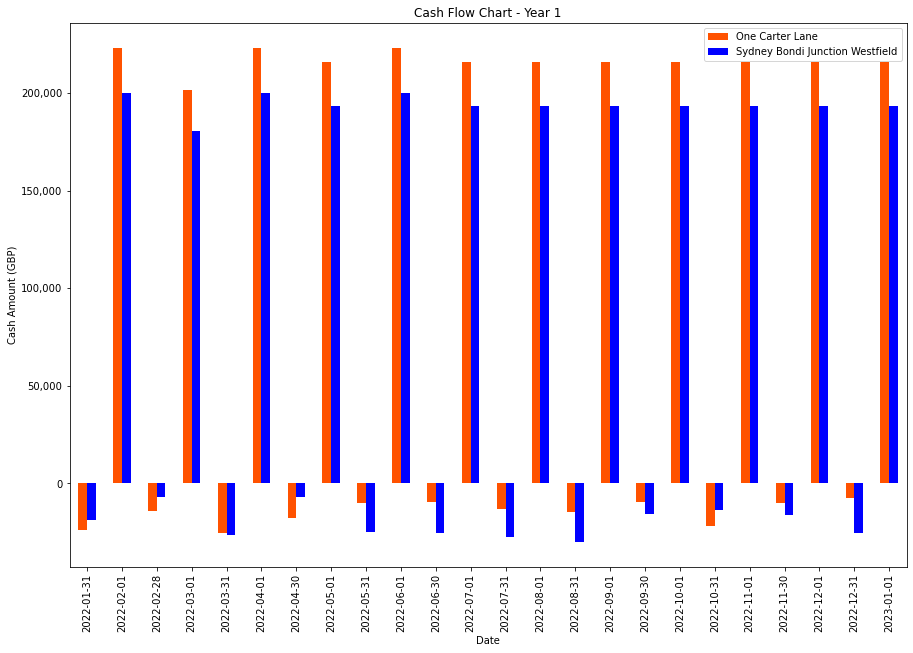

In [70]:
ax = date_cash_flow_df.head(24).plot.bar(y=['One Carter Lane', 'Sydney Bondi Junction Westfield'], color=['#ff5200', '#0000ff'], figsize=[15, 10])

plt.title('Cash Flow Chart - Year 1')
plt.ylabel('Cash Amount (GBP)')
plt.xlabel('Date')

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# Save the graph
plt.savefig('./outputs/cash_flow_y1.png')

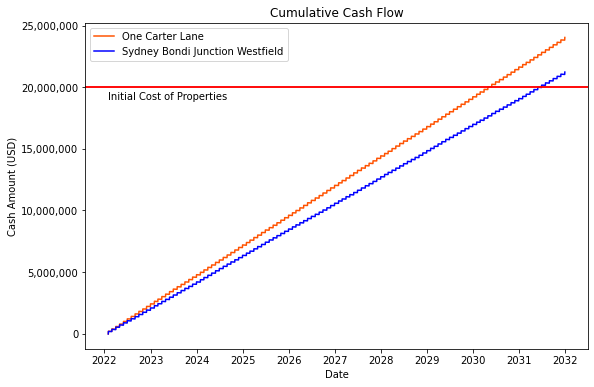

In [71]:
ax = cumulative_cash_flows.plot.line(
    y=['One Carter Lane', 'Sydney Bondi Junction Westfield'], 
    color=['#ff5200', '#0000ff'], 
    figsize=[9, 6]
)

plt.title('Cumulative Cash Flow')
plt.ylabel('Cash Amount (USD)')
plt.xlabel('Date')

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))

plt.axhline(london_intial, color='r')
plt.axhline(sydney_intial, color='r')

ax.annotate(
    'Initial Cost of Properties',
    xy=('2022-01-31 00:00:00+00:00', 19000000), 
    xytext=('2022-01-31 00:00:00+00:00', 19000000)
)

# Save the graph
plt.savefig('./outputs/cumulative_cash_flow.png')

# 8. PDF Report Writer (for Real Estate Fund)

Using the calculations, cash flows and graphs from above, we are able to combine them to produce a concise and informative PDF report.

In [72]:
pdf = FPDF()

# Set cell height
ch = 8

# Title and Logo
pdf.add_page()
pdf.set_font("Arial", style='B', size=14)
pdf.text(txt='Real Estate Report', x=10, y=10)
pdf.image("./data/finbourne.png", x=150, y=3, w=50)
pdf.ln(10)

# Calculations Table header
pdf.set_font("Arial", style='B', size=10)
pdf.set_fill_color(235, 235, 235)
pdf.cell(w=30, h=ch, txt='Type', border=1, ln=0, align='C', fill=True)
pdf.cell(w=80, h=ch, txt='One Carter Lane (OCL)', border=1, ln=0, align='C', fill=True)
pdf.cell(w=80, h=ch, txt='Sydney Bondi Junction Westfield (SBJW)', border=1, ln=1, align='C', fill=True)

# Calculations Table contents
pdf.set_font('Arial', '', 10)
for i in range(0, len(pdf_data)):
    pdf.cell(w=30, h=ch, 
             txt=pdf_data['Type'].iloc[i], 
             border=1, ln=0, align='C')
    pdf.cell(w=80, h=ch, 
             txt=pdf_data['One Carter Lane'].iloc[i], 
             border=1, ln=0, align='C')
    pdf.cell(w=80, h=ch, 
             txt=pdf_data['Sydney Bondi Junction Westfield'].iloc[i], 
             border=1, ln=1, align='C')
pdf.ln(ch)

# Yearly Cashflow header
pdf.set_font("Arial", style='B', size=10)
pdf.set_fill_color(235, 235, 235) # grey
pdf.cell(w=20, h=ch, txt='Year', border=1, ln=0, align='C', fill=True)
pdf.cell(w=20, h=ch, txt='OCL', border=1, ln=0, align='C', fill=True)
pdf.cell(w=20, h=ch, txt='SBJW', border=1, ln=1, align='C', fill=True)

# Yearly Cashflow contents
pdf.set_font('Arial', '', 10)
for i in range(0, len(cash_flow_yearly)):
    pdf.cell(w=20, h=ch, 
             txt=str(cash_flow_yearly.index[i]),
             border=1, ln=0, align='C')
    pdf.cell(w=20, h=ch, 
             txt=str(round(cash_flow_yearly['One Carter Lane'].iloc[i])), 
             border=1, ln=0, align='C')
    pdf.cell(w=20, h=ch, 
             txt=str(round(cash_flow_yearly['Sydney Bondi Junction Westfield'].iloc[i])), 
             border=1, ln=1, align='C')

# Add Cumulative Cash Flow graph
pdf.image("./outputs/cumulative_cash_flow.png", x=75, y=58, w=138)

# Add Yearly Cash Flow graph
pdf.image("./outputs/cash_flow_y1.png", y=140, w=222, x=-5)

# Save PDF
pdf.output("./outputs/real_estate_report.pdf", "F")

# Display PDF
IFrame("./outputs/real_estate_report.pdf", width=800, height=1200)